# sex-stratified for joint model analysis for RI

In [1]:
from datetime import datetime; print("START:", datetime.now())
import socket; print("Simons Foundation, Rusty HPC,", socket.gethostname())

START: 2021-08-19 10:24:23.751702
Simons Foundation, Rusty HPC, worker1024


In [2]:
%cd /mnt/home/zzhang/ceph/jemm
%load_ext rpy2.ipython

/mnt/ceph/users/zzhang/jemm


In [3]:
# import everything we will need from jemm
from jemm.junction import JunctionCountTable
from jemm.transcript import TranscriptMeasureTable
from jemm.model import JemmLinearRegression, JemmLinearMixedModel
from jemm.plots import facet_boxplot
from jemm.covariate import Contrasts, Covariate

In [4]:
import pickle
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn2
plt.style.use(['science', 'no-latex', 'ieee'])


EVENT_TYPE = 'RI'
DATA_VER = 'data-V9'
PCS_TO_INCL = '""'
USE_RE = True
USE_ANNOT = False
MIN_RE_VAR = 0.001  # std=0.031, 1.96*std=0.06~5%
%run ./notebook/navy_utils_sexDiff.py $DATA_VER $PCS_TO_INCL $USE_RE

# Method to use
Jemm = JemmLinearMixedModel if USE_RE is True else JemmLinearRegression

FDR_THRESH = 0.05
FORCE_RERUN = False
OUTDIR = './%s/sex_stratified.%s/' % (DATA_VER, EVENT_TYPE)
FIGDIR = '%s/figs' % OUTDIR

os.makedirs(OUTDIR, exist_ok=True)
os.makedirs(FIGDIR, exist_ok=True)
print(covs.covariate.shape)

navy_utils_sexDiff.py data-V9 [] True
(839, 5)


In [5]:
covs.meta[['pid','Sex','final']].drop_duplicates().groupby(['final','Sex']).size()

final    Sex
Control  F       38
         M      229
First    F       31
         M       58
Mid      F       26
         M      177
dtype: int64

In [6]:
JCT = pickle.load(open("./%s/compiled/jct_%s.pkl" % (DATA_VER, EVENT_TYPE), "rb"))
TXR = pickle.load(open("./%s/compiled/txr_%s.pkl" % (DATA_VER, EVENT_TYPE), "rb"))

In [7]:
from jemm.genomic_annotation import ExonSet
#exonset = ExonSet.from_rmats("./data/rmats/fromGTF.%s.txt" % EVENT_TYPE, event_type=EVENT_TYPE)
exonset = ExonSet.from_suppa("/mnt/ceph/users/zzhang/SUPPA/index/hg38/suppa_gencodev34_%s_strict.ioe"%EVENT_TYPE, 
                             cache_dir='./data/',
                             event_type=EVENT_TYPE)

reloaded 'jemm.genemap.pkl' from cache dir ./data/


## Analysis for Males

In [8]:
# contrasts and covariates
contrasts_m = contrasts + Contrasts(name="Sex", levels=['M'])
covs_m = Covariate(fp="./%s/charm_master.no_seropos.csv" % DATA_VER, sep=",",
                 index_col=0,
                 contrasts=contrasts_m,
                 main_effects=['final', 'plateNum', 'pid'] + PCS_TO_INCL if USE_RE is True \
                   else ['final', 'plateNum'] + PCS_TO_INCL,
                 factor_conversion={
                     'final': {
                         'First': 'final@First',
                         'Mid': 'final@Mid'
                     },
                     'plateNum': {
                         'P2R': 'plateNum@P2R',
                         'P3': 'plateNum@P3',
                         'P4': 'plateNum@P4',
                         'P5': 'plateNum@P5',
                         'P6': 'plateNum@P6',
                         'P7': 'plateNum@P7',
                         'P8': 'plateNum@P8',
                         'P9': 'plateNum@P9',
                         'P10': 'plateNum@P10',
                         'P12': 'plateNum@P12',
                         'P13': 'plateNum@P13',
                         'P14': 'plateNum@P14',
                         'P15': 'plateNum@P15',
                         'P16': 'plateNum@P16',
                         'P17': 'plateNum@P17',
                         'P18': 'plateNum@P18',
                         'P19': 'plateNum@P19',
                         'P20': 'plateNum@P20',
                         'P21': 'plateNum@P21',
                         'P22': 'plateNum@P22',
                         'P23': 'plateNum@P23',
                         'P24': 'plateNum@P24',
                         'P25': 'plateNum@P25',
                     },
                 },
                 verbose=True
             )
print(covs_m.formula)
print(np.linalg.cond(covs_m.to_numpy()))

# init jemm
jem_m = Jemm(
    junction_measure=JCT, 
    transcript_measure=TXR, 
    covariates=covs_m,
    diff_intercept_by_measure=True,
    group_varname='pid',
    min_groupvar=MIN_RE_VAR,
    #optimizer='bfgs'
)


skipped main effect plateNum@P12 because var=0.0000 < 0.0000, disallowed
y = final + plateNum + pid
32178.24098212394


/mnt/ceph/users/zzhang/jemm/jemm/model.py:105: UserWarning: Input covariate matrix has condition number = 32178.24098212394 > 100, indicating the presence of co-linearality; optimization might be unstable.
  _ = self._check_covariate_condition()


In [9]:
outfp = os.path.join(OUTDIR, "male.%s.reg_table.tsv"%EVENT_TYPE)
if FORCE_RERUN is False and os.path.isfile(outfp):
    # reload the results if previous results found
    jem_m.load_regression_table(outfp=outfp)
else:
    # run tests if cannot find previous results
    _ = jem_m.run_tests(test_type='Wald',
                      data="txr",
                      force_diff_intercept=False,
                      force_rerun=True,
                      pval_adjust_method="fdr",
                      nthreads=1
                     )
    # if new run, save the results for future re-use
    jem_m.munge_covariates([
        'final@First',
        'final@Mid'],
        meta_name = "final2cond"
    )
    m_df = jem_m.save_regression_table(outfp, 
                                       exonset=exonset, 
                                       annotations=None,
                                       order_by_covariate='final2cond',
                                       order_by='logP'
                                      )
    m_df.head(3)

/mnt/home/zzhang/workspace/programs/anaconda3/envs/rna-seq/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1847: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0


,darts_id,GeneID,geneSymbol,covariate_names,covariate_est,covariate_var,covariate_qval,final2cond|coef,final2cond|neg.log10(Padj)
darts_id,,,,,,,,,
chr8:+:23566107:23566813:23568321:23568378,chr8:+:23566107:23566813:23568321:23568378,ENSG00000147454,SLC25A37,"intercept,final@First,final@Mid,plateNum@P2R,p...","-0.69885,0.42727,0.30905,0.23002,-0.28090,-0.2...","0.00746,0.00368,0.00118,0.05858,0.01631,0.0751...","7.96e-16,1.09e-09,0.00e+00,1.00,0.19,1.00,1.00...",0.368160,16.0
chr11:-:105025507:105025600:105026225:105026356,chr11:-:105025507:105025600:105026225:105026356,ENSG00000137752,CASP1,"intercept,final@First,final@Mid,plateNum@P2R,p...","0.61520,-0.22789,-0.17220,0.05038,-0.06555,0.0...","0.00146,0.00115,0.00038,0.01408,0.00356,0.0200...","0.00e+00,9.62e-09,0.00e+00,1.00,0.69,1.00,1.00...",-0.200045,16.0
chr17:-:3881626:3881648:3882527:3882564,chr17:-:3881626:3881648:3882527:3882564,ENSG00000004660,CAMKK1,"intercept,final@First,final@Mid,plateNum@P2R,p...","-2.74553,0.27487,0.13340,0.10290,0.06021,-0.02...","0.00190,0.00148,0.00049,0.01823,0.00462,0.0257...","0.00e+00,6.36e-10,2.96e-07,1.00,0.79,1.00,1.00...",0.204135,16.0


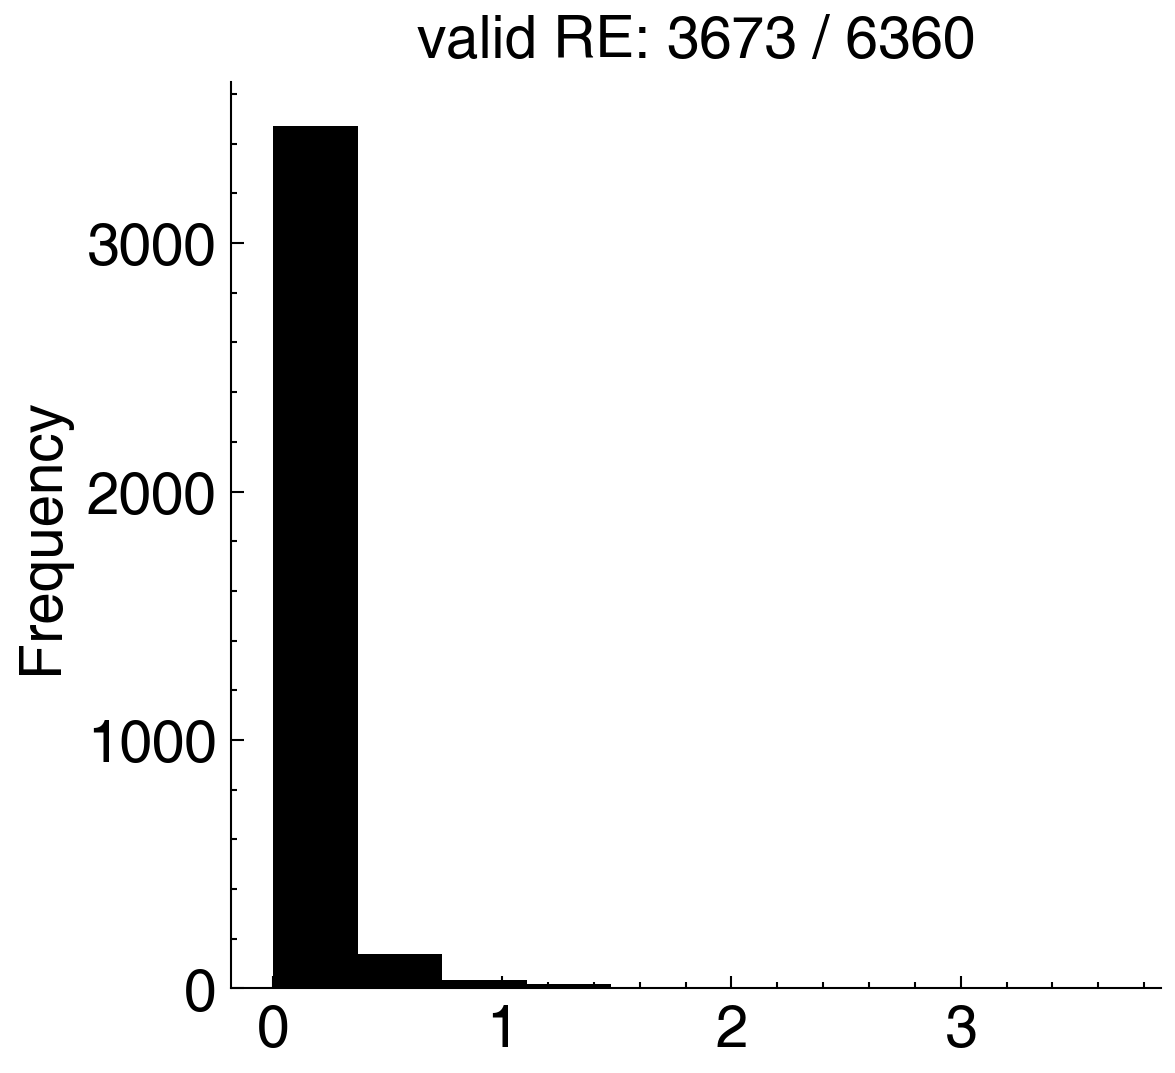

In [10]:
# What's the distribution of Random effect variance estimates?
if USE_RE:
    ax = jem_m.stats_sheet['pid']['coefs'].plot(kind='hist')
    ax.set_title('valid RE: %i / %i' % (pd.notna(jem_m.stats_sheet['pid']['coefs']).sum(), jem_m.stats_sheet['pid'].shape[0]))
    plt.savefig("%s/01-male_random_variance.pdf" % FIGDIR)

## Analysis for Female

In [11]:
# contrasts and covariates
contrasts_f = contrasts + Contrasts(name="Sex", levels= ['F'])
covs_f = Covariate(fp="./%s/charm_master.no_seropos.csv" % DATA_VER, sep=",",
                 index_col=0,
                 contrasts=contrasts_f,
                 main_effects=['final', 'plateNum', 'pid'] + PCS_TO_INCL if USE_RE is True \
                   else ['final', 'plateNum'] + PCS_TO_INCL,
                 factor_conversion={
                     'final': {
                         'First': 'final@First',
                         'Mid': 'final@Mid'
                     },
                     'plateNum': {
                         'P2R': 'plateNum@P2R',
                         'P3': 'plateNum@P3',
                         'P4': 'plateNum@P4',
                         'P5': 'plateNum@P5',
                         'P6': 'plateNum@P6',
                         'P7': 'plateNum@P7',
                         'P8': 'plateNum@P8',
                         'P9': 'plateNum@P9',
                         'P10': 'plateNum@P10',
                         'P12': 'plateNum@P12',
                         'P13': 'plateNum@P13',
                         'P14': 'plateNum@P14',
                         'P15': 'plateNum@P15',
                         'P16': 'plateNum@P16',
                         'P17': 'plateNum@P17',
                         'P18': 'plateNum@P18',
                         'P19': 'plateNum@P19',
                         'P20': 'plateNum@P20',
                         'P21': 'plateNum@P21',
                         'P22': 'plateNum@P22',
                         'P23': 'plateNum@P23',
                         'P24': 'plateNum@P24',
                         'P25': 'plateNum@P25',
                     },
                 },
                 verbose=True
             )
print(covs_f.formula)
# init jemm
jem_f = Jemm(
    junction_measure=JCT, 
    transcript_measure=TXR, 
    covariates=covs_f,
    diff_intercept_by_measure=True,
    group_varname='pid',
    min_groupvar=MIN_RE_VAR,
    #optimizer='lbfgs'
)

skipped main effect plateNum@P2R because var=0.0000 < 0.0000, disallowed
skipped main effect plateNum@P4 because var=0.0000 < 0.0000, disallowed
skipped main effect plateNum@P9 because var=0.0000 < 0.0000, disallowed
skipped main effect plateNum@P12 because var=0.0000 < 0.0000, disallowed
skipped main effect plateNum@P15 because var=0.0000 < 0.0000, disallowed
skipped main effect plateNum@P16 because var=0.0000 < 0.0000, disallowed
skipped main effect plateNum@P17 because var=0.0000 < 0.0000, disallowed
skipped main effect plateNum@P19 because var=0.0000 < 0.0000, disallowed
skipped main effect plateNum@P20 because var=0.0000 < 0.0000, disallowed
skipped main effect plateNum@P21 because var=0.0000 < 0.0000, disallowed
skipped main effect plateNum@P23 because var=0.0000 < 0.0000, disallowed
y = final + plateNum + pid


/mnt/ceph/users/zzhang/jemm/jemm/model.py:105: UserWarning: Input covariate matrix has condition number = 12414.194969565478 > 100, indicating the presence of co-linearality; optimization might be unstable.
  _ = self._check_covariate_condition()


In [13]:
outfp = os.path.join(OUTDIR, "female.%s.reg_table.tsv"%EVENT_TYPE)
if FORCE_RERUN is False and os.path.isfile(outfp):
    # reload the results if previous results found
    jem_f.load_regression_table(outfp=outfp)
else:
    # run tests
    _ = jem_f.run_tests(test_type='Wald',
                      data="txr",
                      force_diff_intercept=False,
                      force_rerun=True,
                      pval_adjust_method="fdr",
                      nthreads=1
                     )
    # if new run, save the results for future re-use
    jem_f.munge_covariates([
        'final@First',
        'final@Mid'],
        meta_name = "final2cond"
    )
    f_df = jem_f.save_regression_table(outfp, 
                                       exonset=exonset, 
                                       annotations=None,
                                       order_by_covariate='finalcond',
                                       order_by='logP'
                                      )
    f_df.head(3)

/mnt/home/zzhang/workspace/programs/anaconda3/envs/rna-seq/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1847: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0
/mnt/ceph/users/zzhang/jemm/jemm/model.py:669: RuntimeWarning: invalid value encountered in true_divide
  chi2_stats = beta_mle ** 2 / mle_var


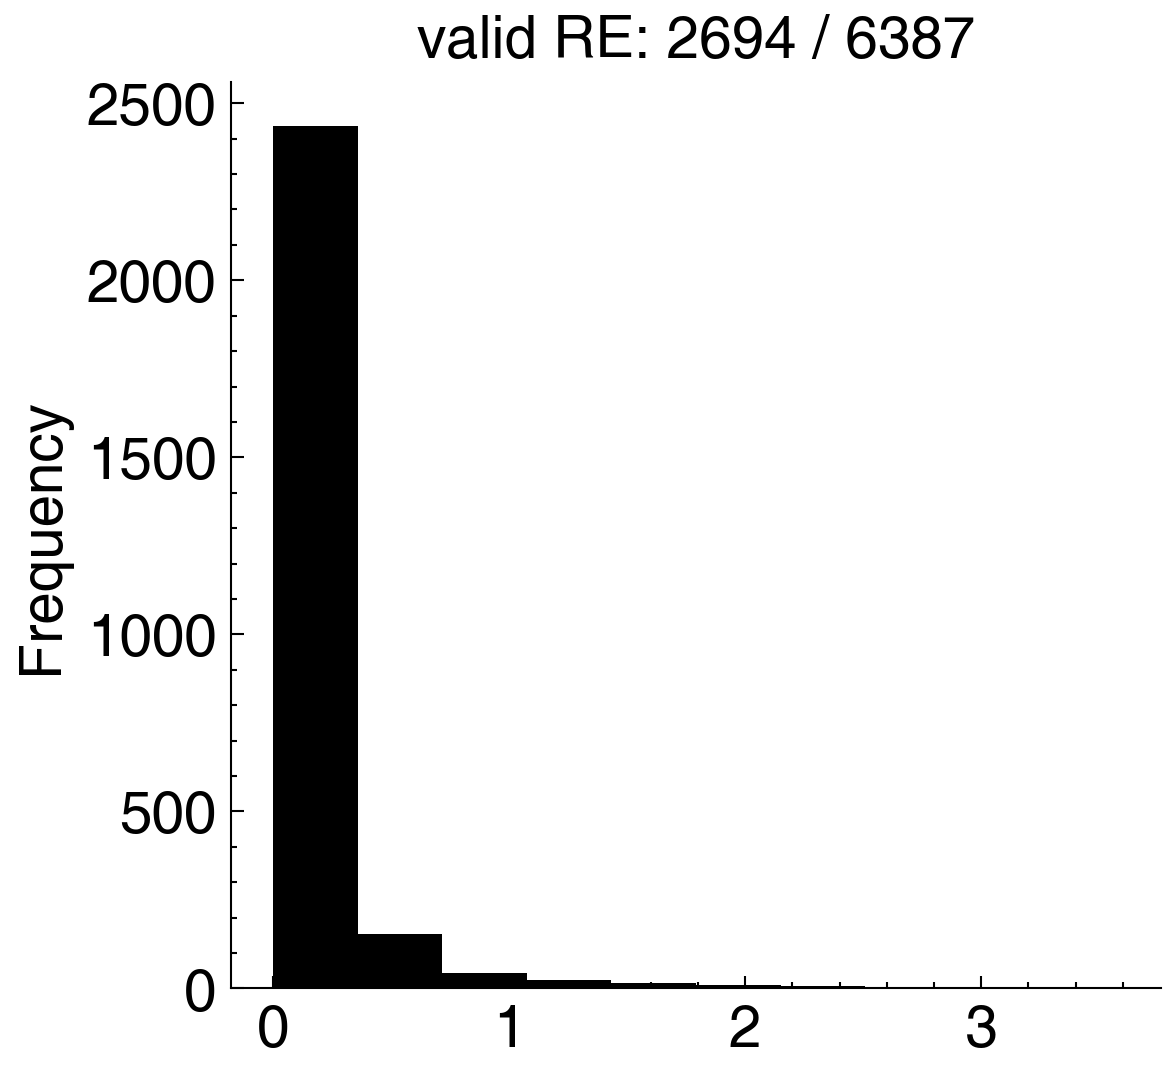

In [14]:
# What's the distribution of Random effect variance estimates?
if USE_RE:
    ax = jem_f.stats_sheet['pid']['coefs'].plot(kind='hist')
    ax.set_title('valid RE: %i / %i' % (pd.notna(jem_f.stats_sheet['pid']['coefs']).sum(), jem_f.stats_sheet['pid'].shape[0]))
    plt.savefig("%s/01-female_random_variance.pdf" % FIGDIR)

## Overlap of sex-specific analysis

In [15]:
print('Female count:')
print(pd.DataFrame(jem_f.get_das_cnt(target_covariate='final', qval_thresh=FDR_THRESH), index=[EVENT_TYPE]))
print('Male count:')
print(pd.DataFrame(jem_m.get_das_cnt(target_covariate='final', qval_thresh=FDR_THRESH), index=[EVENT_TYPE]))

Female count:
    First  Mid
RI     93   91
Male count:
    First  Mid
RI    306  345


In [18]:
target_contrasts = [
    'final@First',
    'final@Mid',
]

In [19]:
from collections import defaultdict
event_catelog = defaultdict(dict)

for eid in jem_m.stats_tests:
    target_ = jem_m.stats_tests[eid].loc[target_contrasts]
    target_ = target_.loc[target_['qvals']<FDR_THRESH]['coef'].to_dict()
    if len(target_):
        event_catelog[eid] = target_

m_up_catelog = {}
m_dn_catelog = {}
for eid in event_catelog:
    ups = [x for x in event_catelog[eid] if event_catelog[eid][x]>0]
    dns = [x for x in event_catelog[eid] if event_catelog[eid][x]<0]
    if len(ups) >= 1:
        m_up_catelog[eid] = ups
    if len(dns) >= 1:
        m_dn_catelog[eid] = dns

print(len(m_up_catelog))
print(len(m_dn_catelog))

282
229


In [20]:
event_catelog = defaultdict(dict)

for eid in jem_f.stats_tests:
    target_ = jem_f.stats_tests[eid].loc[target_contrasts]
    target_ = target_.loc[target_['qvals']<FDR_THRESH]['coef'].to_dict()
    if len(target_):
        event_catelog[eid] = target_

f_up_catelog = {}
f_dn_catelog = {}
for eid in event_catelog:
    ups = [x for x in event_catelog[eid] if event_catelog[eid][x]>0]
    dns = [x for x in event_catelog[eid] if event_catelog[eid][x]<0]
    if len(ups) >= 1:
        f_up_catelog[eid] = ups
    if len(dns) >= 1:
        f_dn_catelog[eid] = dns

print(len(f_up_catelog))
print(len(f_dn_catelog))

87
67


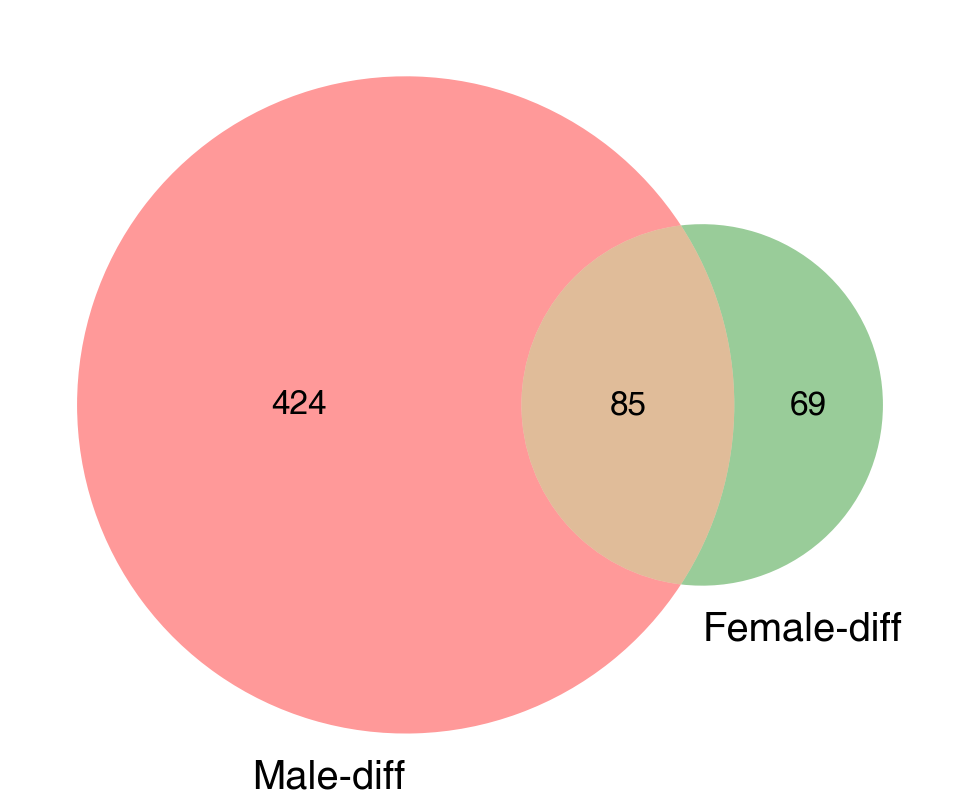

In [21]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn2
m_up = [e for e in m_up_catelog]
m_dn = [e for e in m_dn_catelog]
m_tot = m_up + m_dn
f_up = [e for e in f_up_catelog]
f_dn = [e for e in f_dn_catelog]
f_tot = f_up + f_dn

venn_data = [set(m_tot), set(f_tot)]
venn_name = ['Male-diff', 'Female-diff']

plt.close()
venn2(venn_data[0:2], venn_name[0:2])
plt.savefig("%s/02-venn_sex_diff.pdf" % FIGDIR)
plt.show()

R[write to console]: Loading required package: grid

R[write to console]: Loading required package: futile.logger



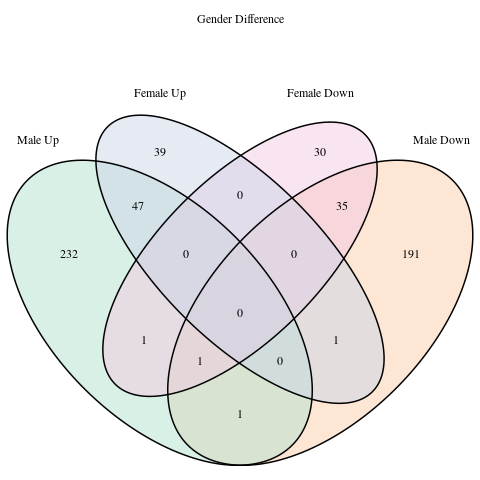

In [22]:
%%R -i m_up -i m_dn -i f_up -i f_dn -i FIGDIR
library(VennDiagram)
library(RColorBrewer)

target_events = list(m_up, m_dn, f_up, f_dn)
target_contrasts = c("Male Up", "Male Down", "Female Up", "Female Down")

myCol <- brewer.pal(4, "Pastel2")
plt = venn.diagram(
  x = target_events,
  category.names = target_contrasts,
  filename=NULL,
  #filename=file.path(FIGDIR, '02-venn_sex_updn_diff.pdf'), 
  fill=myCol,
  output=TRUE,
  main="Sex Difference"
)
grid::grid.draw(plt)

In [34]:
print("FINISH:", datetime.now())

FINISH: 2021-08-19 10:37:44.067399
